<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/feature_map_based_augmentation_by_LGAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue May  4 22:31:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    34W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets
from IPython.utils import io
import numpy as np
import cv2

In [ ]:
print(f'Tf version : {tf.__version__}')

Tf version : 2.4.1


In [ ]:
model = tf.keras.applications.ResNet50V2(
    include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

In [ ]:
!wget -O dog.jpg https://www.sciencemag.org/sites/default/files/styles/article_main_image_-_1280w__no_aspect_/public/dogs_1280p_0.jpg
Image.open('dog.jpg').resize((224,224)).save('dog.jpg')

--2021-05-04 22:31:36--  https://www.sciencemag.org/sites/default/files/styles/article_main_image_-_1280w__no_aspect_/public/dogs_1280p_0.jpg
Resolving www.sciencemag.org (www.sciencemag.org)... 54.215.231.250, 13.57.175.143
Connecting to www.sciencemag.org (www.sciencemag.org)|54.215.231.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145305 (142K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 141.90K   675KB/s    in 0.2s    

2021-05-04 22:31:37 (675 KB/s) - ‘dog.jpg’ saved [145305/145305]



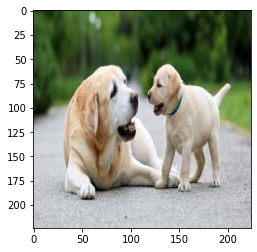

In [ ]:
image = load_img('dog.jpg', target_size=(224,224,3))
plt.imshow(image)
plt.show()

# Grad-CAM Based Augmentation

In [ ]:
def generate_gradcam(img_tensor, model, class_index, activation_layer):

  grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])

  with tf.GradientTape() as tape:
      conv_outputs, predictions = grad_model(img_tensor)
      loss = predictions[:, class_index]

  output = conv_outputs[0]
  grads = tape.gradient(loss, conv_outputs)[0]    
  weights = np.mean(grads, axis=(0, 1))
    
  grad_cam = np.dot(output, weights)
  grad_cam = np.maximum(grad_cam, 0)
  grad_cam -= np.min(grad_cam)
  grad_cam /= (np.max(grad_cam)+1e-10)
  
  return grad_cam

In [ ]:
image = load_img('dog.jpg', target_size=(224,224,3))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.
pred = model.predict(image) 
print("Model prediction: class", np.argmax(pred), ", {:2.2f}%".format(np.max(pred)*100))
class_index = np.argmax(pred)

Model prediction: class 208 , 90.19%


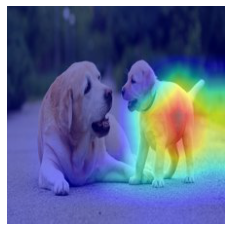

In [ ]:
grad_cam = generate_gradcam(image, model, class_index=class_index, activation_layer="post_relu")
grad_cam =  cv2.resize(grad_cam, (224, 224))
plt.imshow(image[0])
plt.imshow(grad_cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()

Model prediction: class 111 , 1.17%


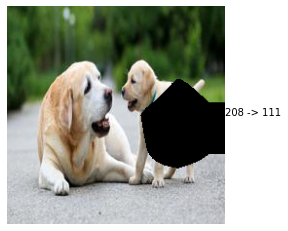

In [ ]:
# Augmented Image
mask = np.zeros_like(grad_cam)
mask[np.where(grad_cam < 0.5)] = 1
occulded_image = np.einsum('hwc, hw -> hwc', image[0], mask)

tmp = np.copy(occulded_image)
img = np.expand_dims(tmp, axis=0)
img /= 255.
pred = model.predict(img) 
print("Model prediction: class", np.argmax(pred), ", {:2.2f}%".format(np.max(pred)*100))
occulded_class_index = np.argmax(pred)
result='{} -> {}'.format(class_index, occulded_class_index)

plt.imshow(occulded_image)
plt.text(224,112,result)
plt.axis('off')
plt.show()

# Feature Map Based Augmentation

In [ ]:
# UTIL
# Felzenszwalb et al
from scipy import ndimage
from skimage.measure import label, regionprops
import matplotlib.patches as patches
import numpy as np

def non_max_suppression_fast(boxes, scores, mask_locs, iou_threshold):
  '''
  boxes : coordinates of each box
  scores : score of each box
  iou_threshold : iou threshold(box with iou larger than threshold will be removed)
	'''
  if len(boxes) == 0:
    return ([])
  
  # Init the picked box info
  pick = []
  mask_locs = np.array(mask_locs)

	# Box coordinate consist of left top and right bottom
  x1 = boxes[:,0]
  y1 = boxes[:,1]
  x2 = boxes[:,2]
  y2 = boxes[:,3]

  # Compute area of each boxes
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  # Greedily select the order of box to compare iou
  idxs = np.argsort(scores)
	
  while (len(idxs) > 0):
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    
    # With vector implementation, we can calculate fast
    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    intersection = w * h
        
    # Calculate the iou
    iou = intersection / (area[idxs[:last]] + area[idxs[last]] - intersection)
    
    idxs = np.delete(idxs, np.concatenate(([last], np.where(iou > iou_threshold)[0])))
        
  return mask_locs[pick].astype("int") #pick	#boxes[pick].astype("int")


def generate_bbox(cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props


In [ ]:
import cv2
from time import time
import numpy as np
import tensorflow as tf

def feature_map_based_aug(images, model, activation_layer, class_index, interp='bilinear', frac=0.15):
    '''
    Make a set of saliency maps and occluded images using each feature map considering overlap

    inputs:
        images: a 4-D tensor image.
        model: the trained classification model
        activation_layer: layer name in which sailiency maps are made.
        class_index: the label number of class that we want to augment.
        interp: upsampling technique.
          For now, 'bilinear' and 'nearest' are supported.
        frac: the pixel ratio for being saliency map among whole image pixels.
    returns:
        X: occluded images.
        pres: predicton results of occluded images
    '''
    assert interp in ['bilinear', 'nearest'], 'You have to select one of bilinear and nearest'
    conv_outputs=[model.get_layer(activation_layer).output, model.output]

    feedforward = tf.keras.models.Model([model.input], [conv_outputs], trainable=False)
    with tf.GradientTape() as tape:
        ff_results = feedforward([images])[0]
        all_fmap_masks, predictions = ff_results[:-1], ff_results[-1]
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, all_fmap_masks)

    masks = all_fmap_masks[0][0].numpy()
    masks = np.einsum('hwc,hwc->hwc', all_fmap_masks[0][0], grads[0][0])

    masks -= np.min(masks, axis=(0,1))
    masks /= (np.max(masks, axis=(0,1))+1e-30)  

    # Calculating NMS
    boxes=[]
    scores =[]
    mask_locs=[]
    for i in range(masks.shape[2]) :
      mask = masks[:,:,i]
      props = generate_bbox(mask, 0.5)
      if len(props) != 0 :
        for k, b in enumerate(props):
          boxes.append(b.bbox)
          xmin, ymin, xmax, ymax = b.bbox[0], b.bbox[1], b.bbox[2], b.bbox[3]
          scores.append(mask[xmin:xmax,ymin:ymax].mean())
          mask_locs.append(i)
    boxes  = np.array(boxes)
    picks = non_max_suppression_fast(boxes, scores, mask_locs, iou_threshold=0.5)
    picks = list(set(picks))
    if len(picks) == 0 :
      picks =[0]
    masks = masks[:,:,picks]
    print ("Number of Selected Feature Maps: ", len(picks))

    # resize to original image
    if interp == 'bilinear':
        masks = tf.image.resize(masks, (224,224), method='bilinear').numpy()
    elif interp == 'nearest':
        masks = tf.image.resize(masks, (224,224), method='nearest').numpy()

    # make binary mask
    w,h,c = masks.shape    
    binary_masks = np.transpose(masks, (2, 0, 1))
    binary_masks_flat = binary_masks.reshape(c,-1)
    _, top_n_idx = tf.math.top_k(
        binary_masks_flat, k=int(w*h*frac), sorted=False, name=None
    )
    top_n_idx = top_n_idx.numpy()

    for j in range(c):
      idx = (top_n_idx[j]//w, top_n_idx[j]%w)
      binary_masks[j] = 1
      binary_masks[j][idx] = 0
    binary_masks = np.transpose(binary_masks, (1, 2, 0))

    # creates occluded images.
    img = images[0]
    X = np.einsum('hwc,hwn->nhwc', img, binary_masks)
    logits_masked = model.predict(X, verbose=0)
    preds_masked = np.argmax(logits_masked, axis=1)

    return X, preds_masked

In [ ]:
image = load_img('dog.jpg', target_size=(224,224,3))
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image /= 255.
pred = model.predict(image) 
print("Model prediction: class", np.argmax(pred), ", {:2.2f}%".format(np.max(pred)*100))
class_index = np.argmax(pred)

Model prediction: class 208 , 90.19%


In [ ]:
## NMS-based
start=time()
occluded_imgs, occluded_preds = feature_map_based_aug(images = image, 
                        model=model, 
                        activation_layer = "post_relu", 
                        class_index = class_index, 
                        interp='bilinear', 
                        frac = 0.15
                        )
print("running time for making augmentation:", time()-start)

Number of Selected Feature Maps:  68
running time for making augmentation: 0.7586197853088379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


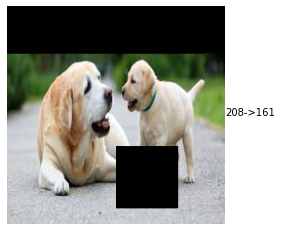

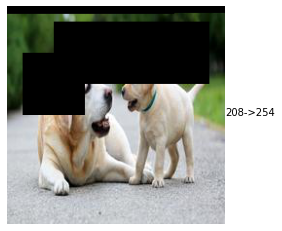

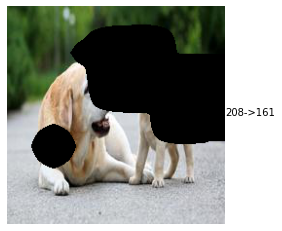

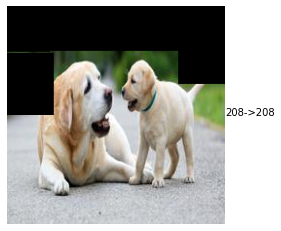

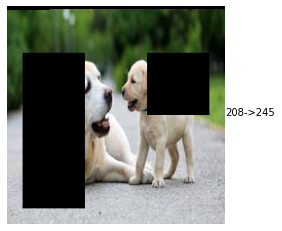

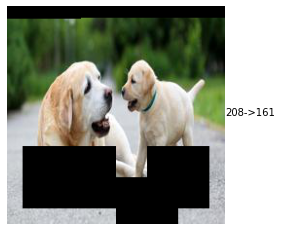

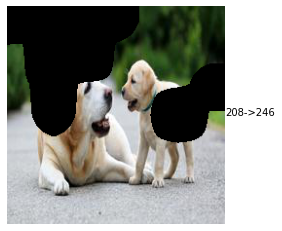

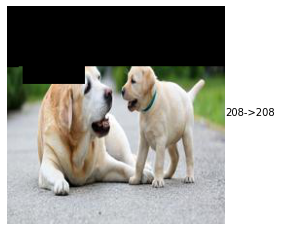

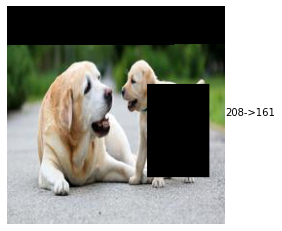

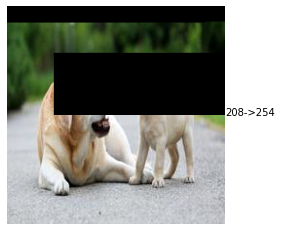

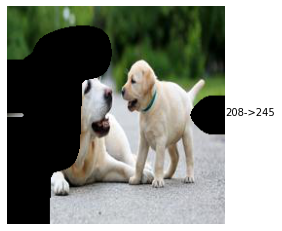

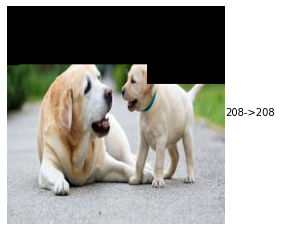

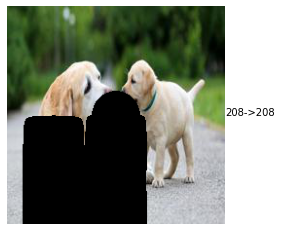

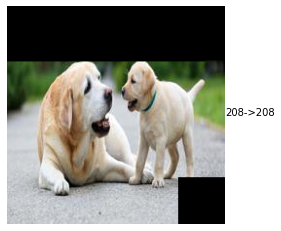

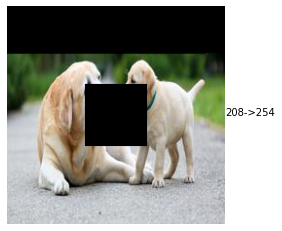

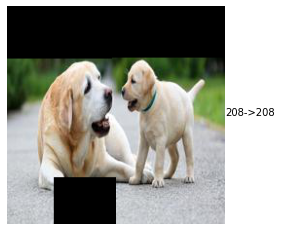

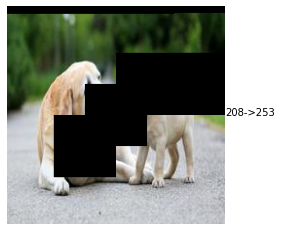

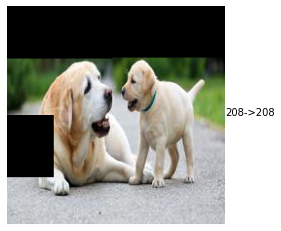

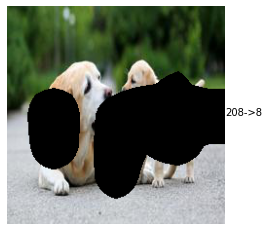

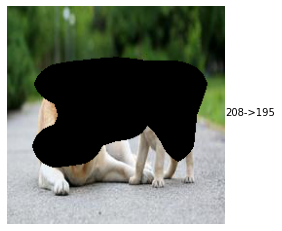

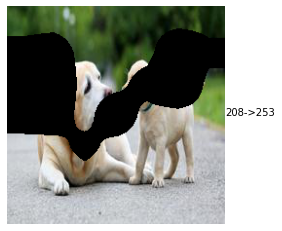

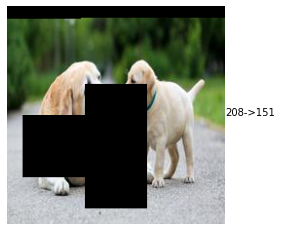

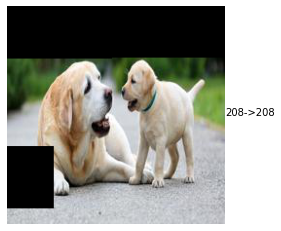

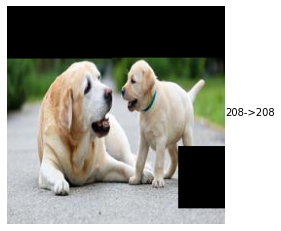

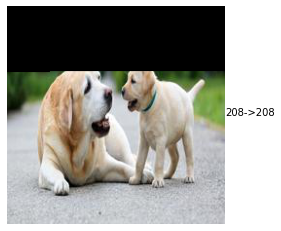

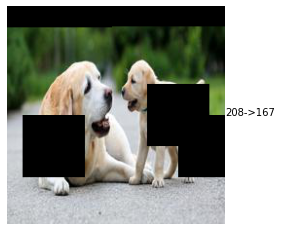

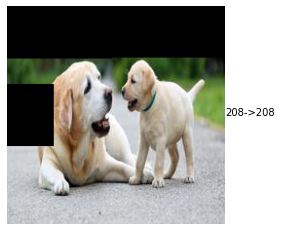

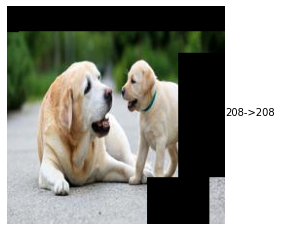

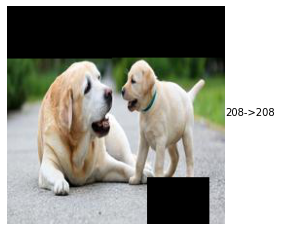

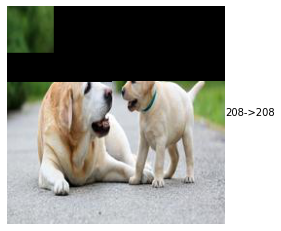

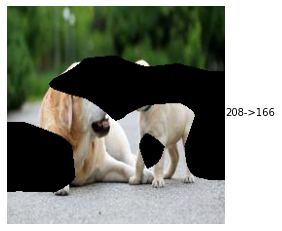

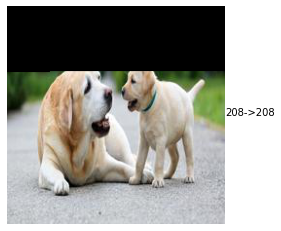

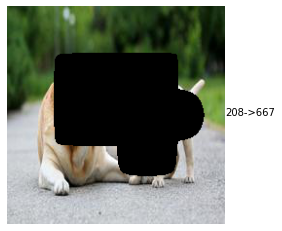

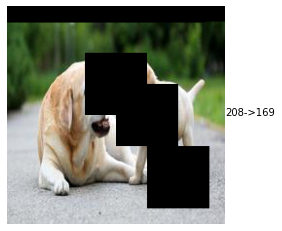

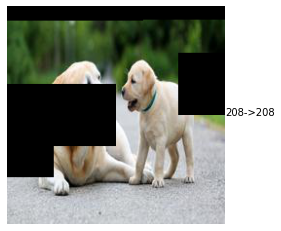

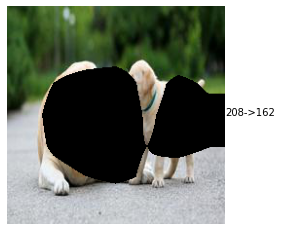

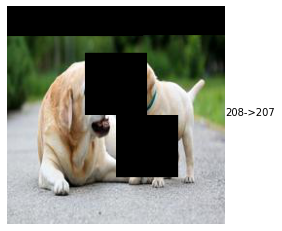

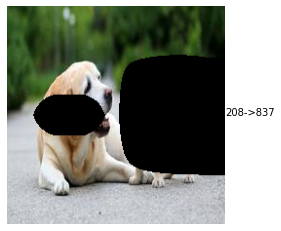

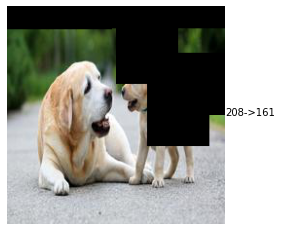

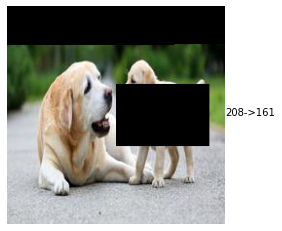

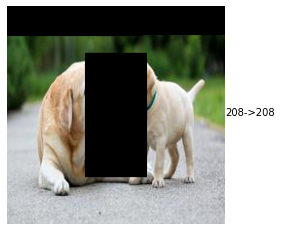

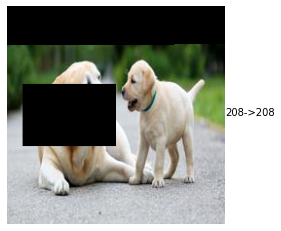

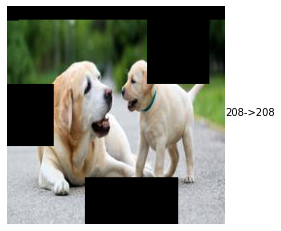

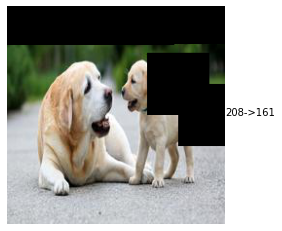

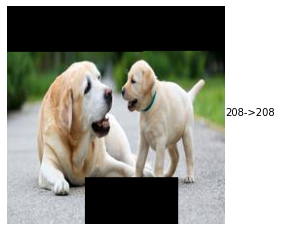

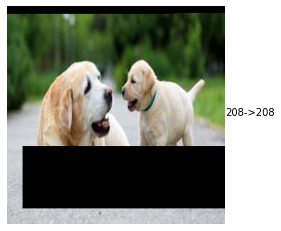

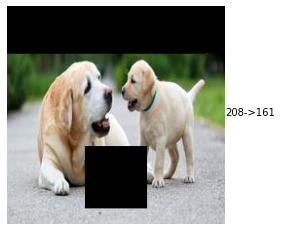

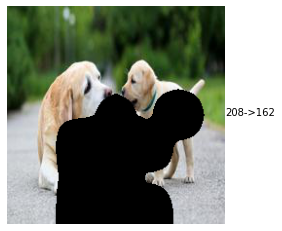

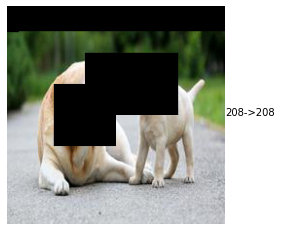

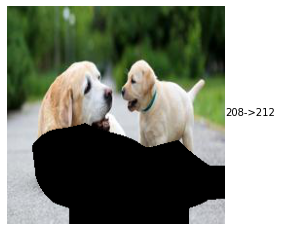

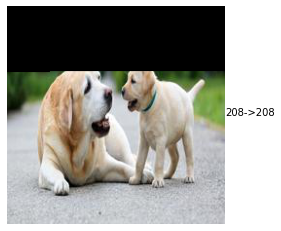

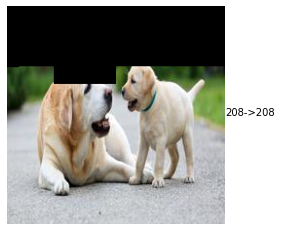

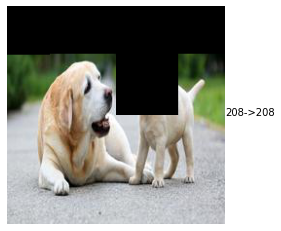

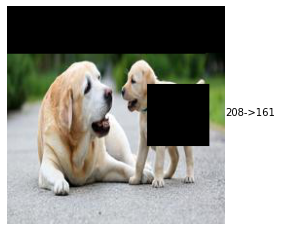

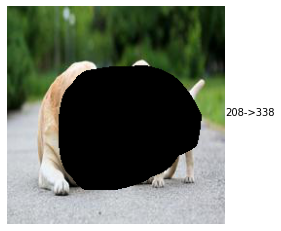

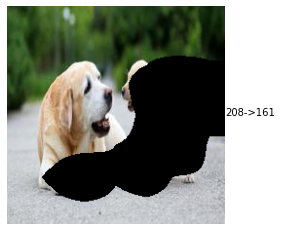

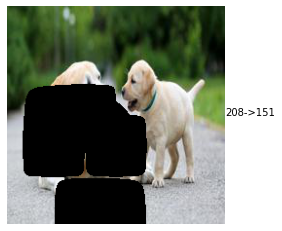

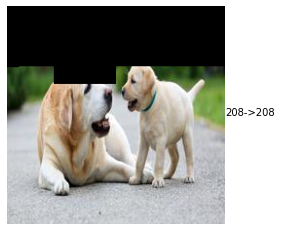

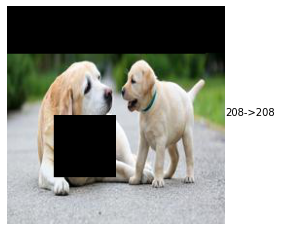

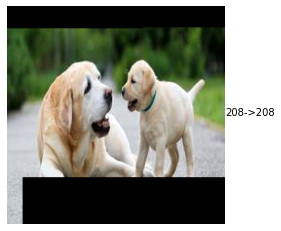

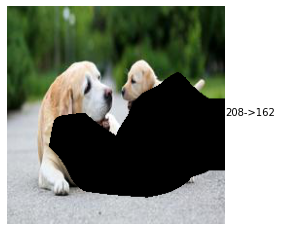

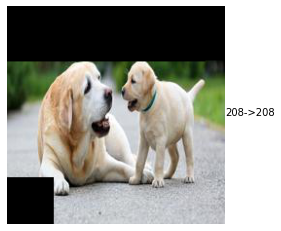

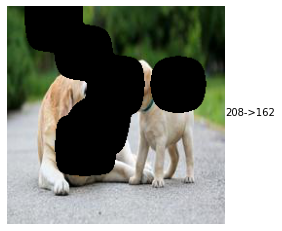

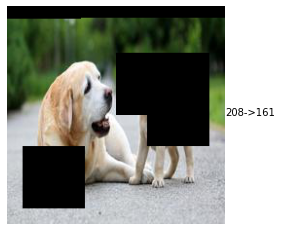

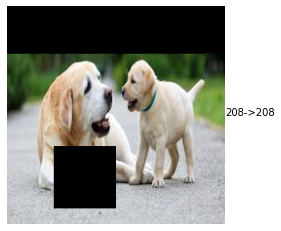

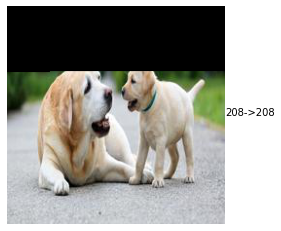

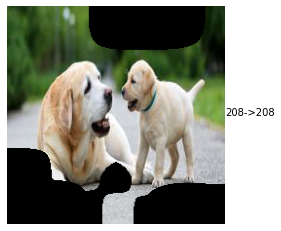

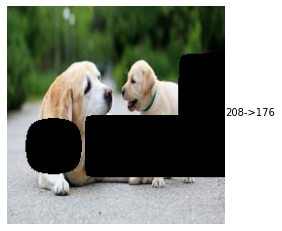

In [ ]:
for i in range(len(occluded_imgs)) :
  plt.figure()
  plt.imshow(occluded_imgs[i])
  result='{}->{}'.format(class_index, occluded_preds[i])
  plt.text(224,112, result)
  plt.axis('off')